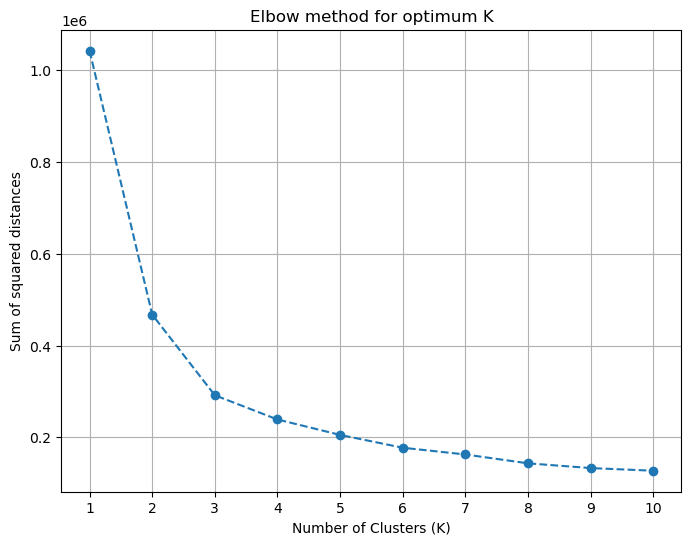

Cluster Centers:
          GP        MPG       USG%        TO%        FTA       FT%  \
0   8.153846  26.729231  18.121538  11.709231  12.692308  0.760323   
1  12.657895  33.802632  21.518421  11.760526  35.500000  0.777158   
2  15.400000  39.430000  29.830000  11.580000  89.100000  0.793800   
3   4.660000   8.426000  15.260000  13.608000   2.040000  0.361680   

          2PA       2P%        3PA       3P%      eFG%       TS%        PPG  \
0   30.984615  0.498723  27.415385  0.302031  0.510446  0.543708  10.492308   
1   92.263158  0.560211  54.394737  0.318132  0.558342  0.588632  16.926316   
2  218.300000  0.533600  94.700000  0.339900  0.528500  0.568500  26.270000   
3    4.770000  0.411600   5.260000  0.191240  0.417150  0.440000   2.195000   

        RPG       APG       SPG       BPG       TPG  
0  4.232308  2.133846  0.758462  0.487692  1.220000  
1  6.542105  3.476316  0.855263  0.794737  1.736842  
2  7.220000  6.120000  1.170000  0.620000  2.720000  
3  1.428000  0.55300

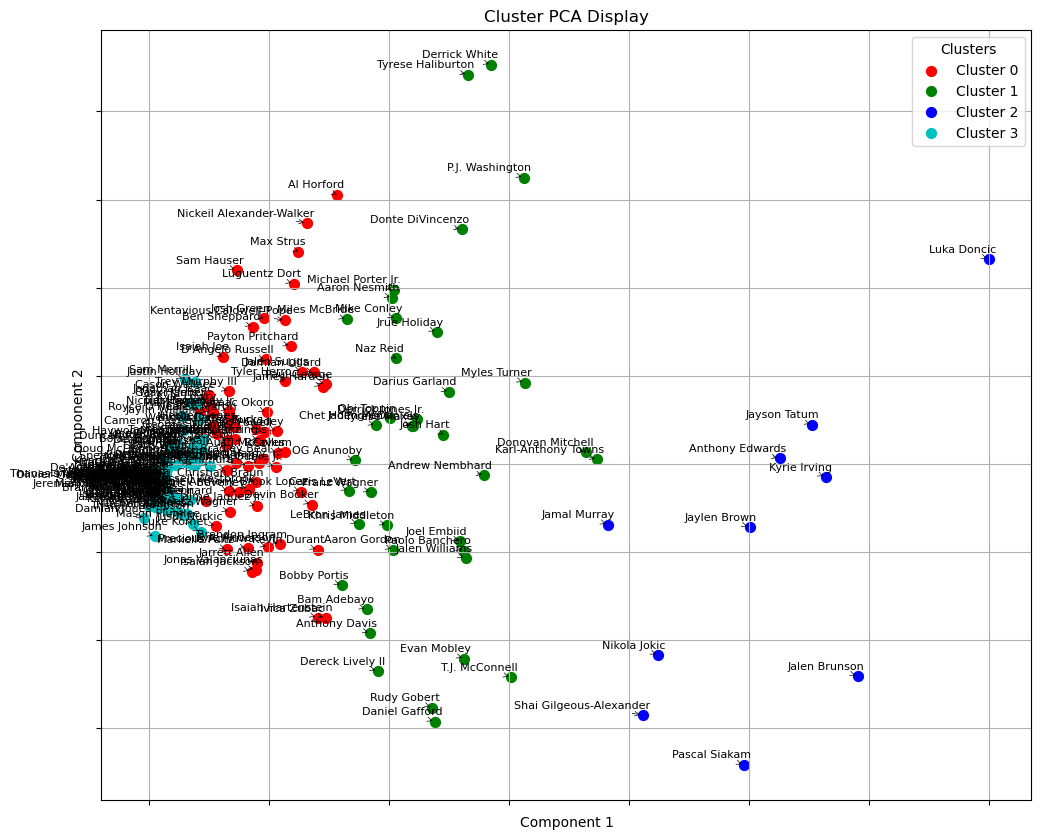

In [3]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load Excel file
file_path = 'NBAStats.xlsx'
sheet_name = 'AllStats'
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Selecting the relevant columns for clustering (columns F to W, index 5 to 23)
X = df.iloc[:, 5:23].values  

# Initialize an empty list to store the sum of squared distances
sse = []

# Fit KMeans and calculate SSE for different values of K
for k in range(1, 11):  # Testing for K from 1 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), sse, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method for optimum K')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

# Assuming the optimal number of clusters is determined to be 4 from the elbow method
optimal_k = 4

# Fit KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# Print cluster centers
print("Cluster Centers:")
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=df.columns[5:23])
print(cluster_centers)

# Selecting the relevant columns for clustering
columns_to_select = ['NAME'] + list(df.columns[5:23])
df_selected = df[columns_to_select + ['Cluster']]

# Display the selected DataFrame with cluster labels
print(df_selected[['NAME', 'Cluster']])

# Display number of players per cluster
print("\nNumber of players per cluster:")
cluster_counts = df['Cluster'].value_counts()
print(cluster_counts)

# Reduce the dimensionality to 2D using PCA for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])
pca_df = pd.concat([pca_df, df[['Cluster', 'NAME']]], axis=1)

# Calculate and display variance between clusters in percentage
print("\nVariance between clusters in percentage based on PCA components:")

# Group by cluster and calculate the variance of each principal component
pca_cluster_variance = pca_df.groupby('Cluster')[['Principal Component 1', 'Principal Component 2']].var()
exp_var_pca = pca.explained_variance_ratio_

# Calculate the total variance for scaling purposes
total_variance = pca_df[['Principal Component 1', 'Principal Component 2']].var().sum()

# Calculate variance in percentage
pca_cluster_variance_percentage = (pca_cluster_variance / total_variance) * 100
print(pca_cluster_variance_percentage)

# Plot the plot with clusters and player names
plt.figure(figsize=(12, 10))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
for cluster in range(optimal_k):
    clustered_data = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(clustered_data['Principal Component 1'], clustered_data['Principal Component 2'], 
                label=f'Cluster {cluster}', color=colors[cluster % len(colors)], s=50)
    for i in range(len(clustered_data)):
        plt.annotate(clustered_data['NAME'].iloc[i],
                     (clustered_data['Principal Component 1'].iloc[i], clustered_data['Principal Component 2'].iloc[i]),
                     textcoords="offset points",
                     xytext=(5,5),
                     ha='right', fontsize=8, arrowprops=dict(arrowstyle='->', lw=0.5))
        
# Remove labels for PCA plot while keeping the grid
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.title('Cluster PCA Display')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Clusters')
plt.grid(True)
plt.show()


In [4]:
exp_var_pca

array([0.81822367, 0.09344628])

# Clusters Interpretation 

**Cluster 0 "Primary Playmakers"** consists of high-usage offensive playmakers, predominantly guards with one versatile center. These players are central to their teams' offenses, with high usage rates and efficient scoring, as seen in their strong true shooting percentages and free throw accuracy. They average high points per game and are adept playmakers, recording significant assist numbers, though their high ball-handling involvement leads to moderate turnover rates. Overall, this cluster represents players who are both scoring and playmaking threats, essential to their team's offensive flow.

**Cluster 1 "Supporting Role Players"** includes low-usage role players across various positions, such as guards and forwards. These players contribute in more specific, less prominent roles with low usage rates, scoring fewer points per game and showing less efficiency in shooting, evidenced by inconsistent true shooting and free throw percentages. Their lower assist and scoring numbers indicate that they are not primary playmakers or scorers, instead focusing on supplementary roles within the team structure. While their defensive contributions are limited, their presence helps in secondary functions, making them valuable but less central to the team's offensive strategy.

**Cluster 2 "Elite Offesnive Stars"** is composed of elite offensive focal points, featuring players with very high usage rates, heavy scoring volume, and significant playmaking abilities. They dominate their teams' offensive production, scoring efficiently and often driving to the basket, drawing fouls, and converting at the free-throw line. These players also excel in playmaking, as seen by their high assist numbers, and some contribute heavily in rebounding, particularly among forwards and centers. Their high turnover rates reflect their constant involvement in offensive plays, making them essential to their teams' success and functioning as primary stars.

**Cluster 3 "Balanced Contributors"** contains well-rounded, efficient players spread across different positions, including forwards, centers, and guards, who contribute moderately in various aspects of the game. With medium usage rates, these players score efficiently, maintain solid true shooting percentages, and play key supporting roles on both offense and defense. Their contributions are balanced, with moderate points and rebounds per game, along with a stronger defensive presence seen in their blocks and steals. While not the focal points of their teams, they provide crucial support, making them reliable in both offensive and defensive duties.

# Filtered Data GP>=8

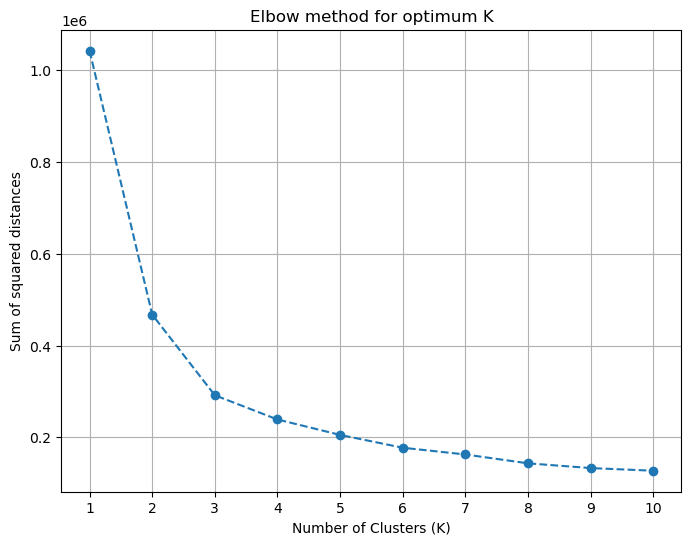

Cluster Centers:
          GP        MPG       USG%        TO%        FTA       FT%  \
0   8.153846  26.729231  18.121538  11.709231  12.692308  0.760323   
1  12.657895  33.802632  21.518421  11.760526  35.500000  0.777158   
2  15.400000  39.430000  29.830000  11.580000  89.100000  0.793800   
3   4.660000   8.426000  15.260000  13.608000   2.040000  0.361680   

          2PA       2P%        3PA       3P%      eFG%       TS%        PPG  \
0   30.984615  0.498723  27.415385  0.302031  0.510446  0.543708  10.492308   
1   92.263158  0.560211  54.394737  0.318132  0.558342  0.588632  16.926316   
2  218.300000  0.533600  94.700000  0.339900  0.528500  0.568500  26.270000   
3    4.770000  0.411600   5.260000  0.191240  0.417150  0.440000   2.195000   

        RPG       APG       SPG       BPG       TPG  
0  4.232308  2.133846  0.758462  0.487692  1.220000  
1  6.542105  3.476316  0.855263  0.794737  1.736842  
2  7.220000  6.120000  1.170000  0.620000  2.720000  
3  1.428000  0.55300

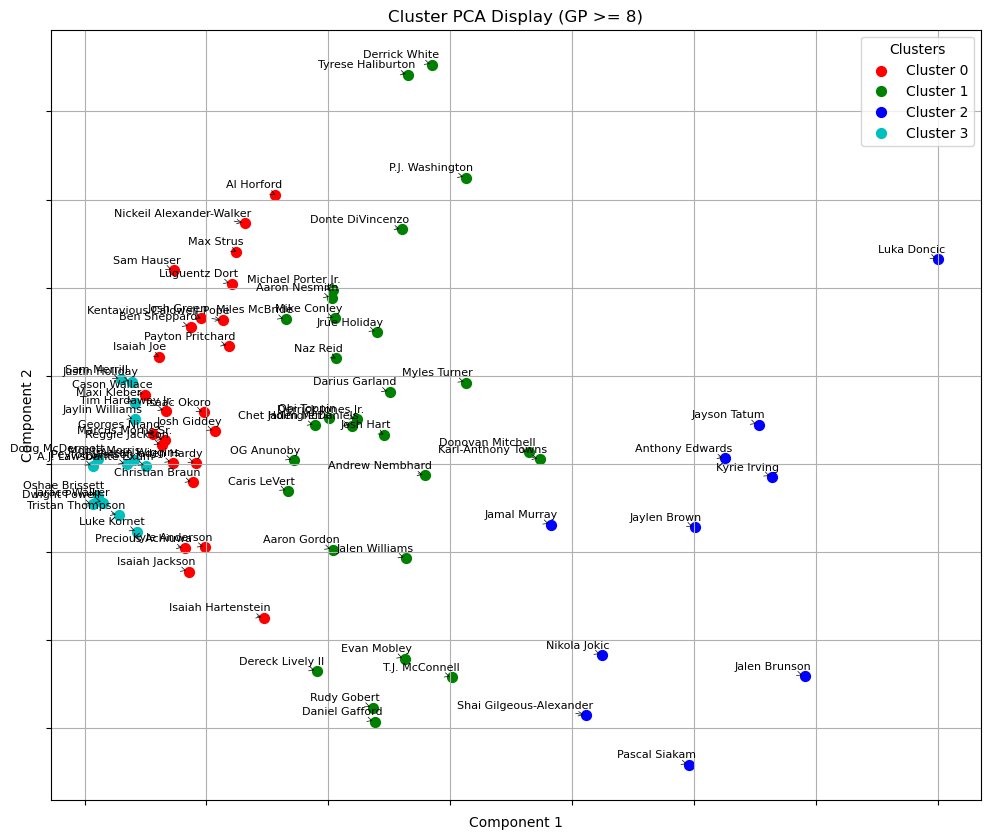

In [3]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load Excel file
file_path = 'NBAStats.xlsx'
sheet_name = 'AllStats'
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Selecting the relevant columns for clustering (columns F to W, index 5 to 23)
X = df.iloc[:, 5:23].values  

# Initialize an empty list to store the sum of squared distances
sse = []

# Fit KMeans and calculate SSE for different values of K
for k in range(1, 11):  # Testing for K from 1 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), sse, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method for optimum K')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

# Assuming the optimal number of clusters is determined to be 4 from the elbow method
optimal_k = 4

# Fit KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# Print cluster centers
print("Cluster Centers:")
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=df.columns[5:23])
print(cluster_centers)

# Selecting the relevant columns for clustering
columns_to_select = ['NAME'] + list(df.columns[5:23])
df_selected = df[columns_to_select + ['Cluster']]

# Display the selected DataFrame with cluster labels
print(df_selected[['NAME', 'Cluster']])

# Display number of players with GP >= 8 per cluster
# Filter the DataFrame for players with GP >= 8
df_filtered = df[df[df.columns[5]] >= 8]  # GP is in column 5

print("\nNumber of players with GP >= 8 per cluster:")
cluster_counts_filtered = df_filtered['Cluster'].value_counts()
print(cluster_counts_filtered)

# Reduce the dimensionality to 2D using PCA for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])
pca_df = pd.concat([pca_df, df[['Cluster', 'NAME', df.columns[5]]]], axis=1)  # Add GP (column 5) to the dataframe

# Filter out players with GP >= 8 for the visualization
pca_df_filtered = pca_df[pca_df[df.columns[5]] >= 8]

# Plot the plot with clusters and player names (GP >= 8 players only)
plt.figure(figsize=(12, 10))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
for cluster in range(optimal_k):
    clustered_data = pca_df_filtered[pca_df_filtered['Cluster'] == cluster]
    plt.scatter(clustered_data['Principal Component 1'], clustered_data['Principal Component 2'], 
                label=f'Cluster {cluster}', color=colors[cluster % len(colors)], s=50)
    for i in range(len(clustered_data)):
        plt.annotate(clustered_data['NAME'].iloc[i],
                     (clustered_data['Principal Component 1'].iloc[i], clustered_data['Principal Component 2'].iloc[i]),
                     textcoords="offset points",
                     xytext=(5,5),
                     ha='right', fontsize=8, arrowprops=dict(arrowstyle='->', lw=0.5))

# Remove labels for PCA plot while keeping the grid
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.title('Cluster PCA Display (GP >= 8)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Clusters')
plt.grid(True)
plt.show()
